#### Load and Inspect the Data

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/Insurance.csv")

# Preview structure
print("Shape:", df.shape)
df.head()

Shape: (2082, 23)


,Customer ID,Age,Gender,Marital Status,Occupation,Income Level,Education Level,Geographic Information,Location,Purchase History,...,Coverage Amount,Premium Amount,Deductible,Policy Type,Preferred Communication Channel,Preferred Contact Time,Risk Profile,Credit Score,Driving Record,Life Events
0,15043,48,Female,Single,Engineer,72654,Associate Degree,Karnataka,75177,1/24/2020,...,387399,1713,1413,Group,Email,Morning,0,649,Major Violations,Divorce
1,88777,50,Male,Divorced,Manager,93448,Master's Degree,Karnataka,56707,1/10/2023,...,621476,2416,1383,Group,Email,Evening,2,540,Clean,Divorce
2,62911,53,Male,Widowed,Doctor,92558,Doctorate,Arunachal Pradesh,60225,12/12/2021,...,775683,3765,1165,Group,In-Person Meeting,Afternoon,3,573,DUI,Childbirth
3,38955,38,Male,Widowed,Salesperson,78536,High School Diploma,Andhra Pradesh,34707,2/1/2023,...,580924,3204,1345,Business,Email,Weekends,2,550,DUI,Marriage
4,3935,42,Male,Married,Salesperson,90220,High School Diploma,Puducherry,14225,2/18/2021,...,711361,2941,1111,Group,In-Person Meeting,Morning,3,568,Clean,Childbirth


#### 1. Ranked Premium Drivers

**Goal:** Identify which customer features most strongly influence premium amount.

C:\Users\User\AppData\Local\Temp\ipykernel_13796\4168629513.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


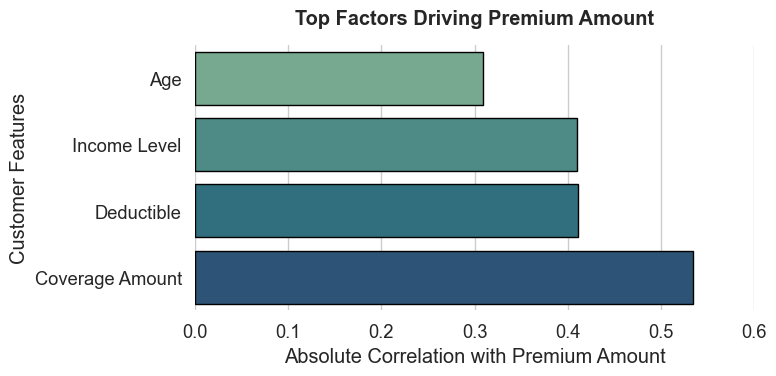

In [54]:
drivers = (
    df[['Premium Amount','Coverage Amount','Deductible','Income Level','Age']]
    .corr()['Premium Amount']
    .drop('Premium Amount')
    .abs()
    .sort_values()
)

sns.set_theme(style="whitegrid", font_scale=1.2)  

plt.figure(figsize=(8,4))
sns.barplot(
    x=drivers.values,
    y=drivers.index,
    palette="crest",
    edgecolor="black"
)

plt.title("Top Factors Driving Premium Amount", weight='bold', pad=15)
plt.xlabel("Absolute Correlation with Premium Amount")
plt.ylabel("Customer Features")      
plt.xlim(0, 0.6)                  
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig("Visualization/ranked_premium_drivers.png", dpi=300)
plt.show()


**Insight:** Coverage Amount shows the highest positive correlation with Premium Amount, followed by Deductible and Income Level. Age has a smaller but noticeable effect. This confirms that coverage size and deductible levels are the main levers for pricing.

#### 2. Segment Size Chart

**Goal:** Show how the three K-Means clusters differ in customer count and average premium, and provide a quick profile of each segment.

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = df[['Premium Amount','Coverage Amount','Deductible','Age']]
scaled = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Segment'] = kmeans.fit_predict(scaled)


C:\Users\User\AppData\Local\Temp\ipykernel_13796\325508444.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


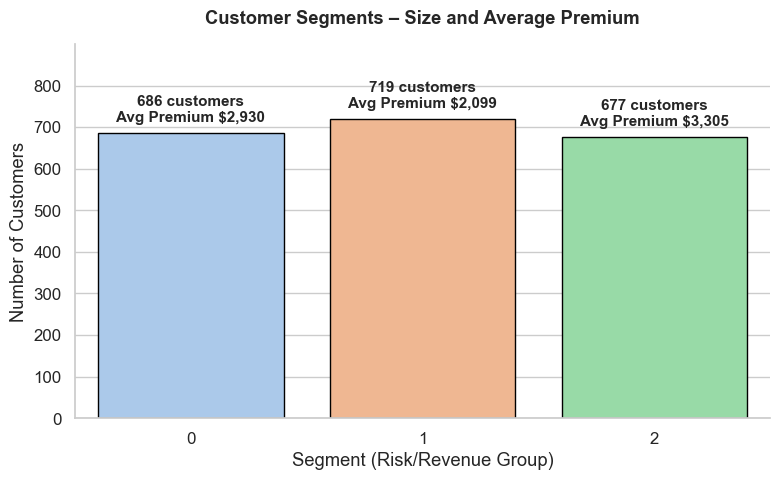

In [56]:
segment_counts = df['Segment'].value_counts().sort_index()
segment_avg_premium = df.groupby('Segment')['Premium Amount'].mean().round(0)

# Prepare text labels with both count and average premium
labels = [
    f"{c} customers\nAvg Premium ${p:,.0f}"
    for c, p in zip(segment_counts.values, segment_avg_premium.values)
]

sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=segment_counts.index,
    y=segment_counts.values,
    palette="pastel",
    edgecolor="black"
)

# Annotate each bar with both count and avg premium
for i, (count, text) in enumerate(zip(segment_counts.values, labels)):
    ax.text(i, count + 20, text,
            ha='center', va='bottom',
            fontsize=11, fontweight='bold')

plt.title("Customer Segments – Size and Average Premium", weight='bold', pad=15)
plt.xlabel("Segment (Risk/Revenue Group)")
plt.ylabel("Number of Customers")
plt.ylim(0, segment_counts.max() * 1.25)
sns.despine()
plt.tight_layout()
plt.savefig("Visualization/customer_segments.png", dpi=300)
plt.show()


### Segment Profiles (based on clustering features)

After clustering on **Premium Amount, Coverage Amount, Deductible, and Age**,  
the three segments can be described as:

- **Segment 0 – Balanced / Medium Risk**  
  - Average Premium: ~\$2,930  
  - Medium coverage and deductible, moderate age.  
  - Represents mid-risk customers who pay moderate premiums.

- **Segment 1 – Low Premium / Lower Revenue**  
  - Average Premium: ~\$2,100  
  - Generally younger customers with lower coverage and higher deductibles.  
  - Lowest profitability but possibly lower claim cost.

- **Segment 2 – High Premium / High Revenue**  
  - Average Premium: ~\$3,300  
  - Higher coverage amounts and slightly older age group.  
  - Most profitable group but potentially higher risk.


**Insight**: All three segments are roughly equal in size, but Segment 2 clearly generates the highest average premium, making it a prime target for retention and upsell strategies. Segment 1 has the largest customer count yet the lowest revenue, suggesting an opportunity to raise premiums or cross-sell additional coverage.

#### 3. Segment Profitability

**Goal:** Compare average premium across segments to highlight revenue potential.

C:\Users\User\AppData\Local\Temp\ipykernel_13796\3910319563.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


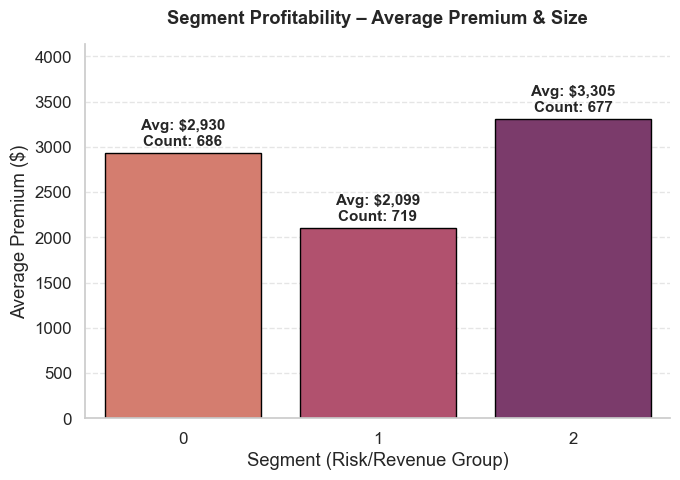

In [57]:
segment_profit = df.groupby('Segment')['Premium Amount'].mean().round(0)
segment_counts = df['Segment'].value_counts().sort_index()

plt.figure(figsize=(7,5))
ax = sns.barplot(
    x=segment_profit.index,
    y=segment_profit.values,
    palette="flare",
    edgecolor="black"
)

# Annotate each bar with both average premium and customer count
for i, (avg, count) in enumerate(zip(segment_profit.values, segment_counts.values)):
    ax.text(i, avg + 50,
            f"Avg: ${avg:,.0f}\nCount: {count}",
            ha='center', va='bottom',
            fontsize=11, fontweight='bold')

plt.title("Segment Profitability – Average Premium & Size", weight='bold', pad=15)
plt.xlabel("Segment (Risk/Revenue Group)")
plt.ylabel("Average Premium ($)")
plt.ylim(0, segment_profit.max()*1.25)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.savefig("Visualization/segment_profitability.png", dpi=300)
plt.show()

**Insight:** Segment 2 customers generate the highest revenue per policy, Segment 0 sits in the middle, and Segment 1 is the least profitable. This helps prioritize marketing or retention efforts toward the most valuable group.

#### Summary

This segmentation reveals three similarly sized customer groups with distinct revenue and risk patterns:
- **Premium Drivers:** Coverage amount is the strongest factor influencing premiums.
- **Risk vs Revenue:** Segment 2 yields the highest revenue per customer, while Segment 1 remains under-monetized.
- **Retention & Upsell:** Segment 2 requires strong retention strategies to protect revenue, and Segment 1 offers a clear upsell opportunity.